In [1]:
from visualizer import *
from visualizer_supcon import *

/home/jinsu/anaconda3/envs/dl_mmd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinsu/anaconda3/envs/dl_mmd/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jinsu/anaconda3/envs/dl_mmd/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
opt = parse_option()

# Visualize

In [214]:
class VisHandler():
    """
    - 1) Embedding 기반 Loader 받아서 Zero-shot prediction, Embeddings reduction 등 수행.
      - 1.1) Adapter 학습 하고 난 다음의 pth도 저장해놨으니, 불러와서 임베딩 똑같이 뽑을 수 있음.
      - 1.2) Linear probing / Adapter 등 학습 시 results/...에 결과 저장됨. 
    """
    def __init__(self, args):
        """
        Initialized by arguments for "single run"
        """
        self.args = args
        self.device = (torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'))
    
        # self.train_results = EasyDict(read_pickle_file(os.path.join(self.run_path, 'full_dict.pickle')))
        self.final_results = {} # Best Train / Val / Text
        
        if self.args.dataset == "waterbirds" :
            self.legend_labels_dict = {"target": {0: "Landbird", 1: "Waterbird"}, "spurious": {0: "Land-background", 1:"Water-background"}, 
                            "group": {0: "Landbird on Land-background", 1: "Landbird on Water-background",
                                        2: "Waterbird on Land-background", 3: "Waterbird on Water-background"},
                            "prediction": {0: "Pred. to Landbird",
                                            1: "Pred. to Waterbird"}}

        self.model = None
        self.text_embeddings = []
        self.group_wise_stat_ebd = {}
        self.group_wise_stat_conf = {}
        
        self.epoch = 0
    
    def SaveWaterbirdsDatasets(self, trainset):
        self.train_set = trainset
    
    def SaveWaterbirdsLoaders(self, train_loader, val_loader, test_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def SaveTextEmbeddings(self, embedding_dir):
        self.text_embeddings.extend(get_text_embedding(embedding_dir, return_key=True))
    
    def SaveModel(self, classifier):
        self.classifier = classifier
        
    def SaveUtils(self, criterion, get_yp_func, train_group_ratio):
        self.criterion = criterion
        self.get_yp_func = get_yp_func
        self.train_group_ratio = train_group_ratio
        
    def SaveZeroShotResults(self, train_loader, val_loader, test_loader):
        self.zs_results = {}
        _, _, train_group_acc = validate_zs(self.args, train_loader, self.classifier, self.criterion, self.get_yp_func, self.train_group_ratio, target="class", print_label='Get ZS Acc. of train (class)')    
        _, _, val_group_acc = validate_zs(self.args, val_loader, self.classifier, self.criterion, self.get_yp_func, self.train_group_ratio, target="class", print_label='Get ZS Acc. of val (class)')    
        _, _, test_group_acc = validate_zs(self.args, test_loader, self.classifier, self.criterion, self.get_yp_func, self.train_group_ratio, target="class", print_label='Get ZS Acc. of test (class)')    
        self.zs_results['train'] = train_group_acc
        self.zs_results['val'] = val_group_acc
        self.zs_results['test'] = test_group_acc
    
    def GetEmbeddings(self, dataloader):
        # # NOTE Adapter 학습 이후 모델 받아서 추출하는 라인 추가해야함.
        
        total_embeddings = []

        total_labels = []
        total_spuriouss = []
        total_groups = []
        # total_confidences = []
        total_predictions = [] # Zero-shot

        print('> Saving activations')

        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc='Running inference')):
                embeddings, labels_dict, _= data
                labels = labels_dict["class"]
                groups = labels_dict["group"]
                places = labels_dict["spurious"]
                predicted = labels_dict["ebd_y_pred"]

                total_labels.extend(labels.numpy())
                total_groups.extend(groups.numpy())
                total_spuriouss.extend(places.numpy())
                total_predictions.extend(predicted.numpy())
                total_embeddings.extend(embeddings.numpy())
                
                del embeddings; del labels; del groups; del places; del predicted

        total_embeddings = np.array(total_embeddings) # (# of full data, feat_dim)

        total_meta_results = {"targets" : total_labels, "spuriouss": total_spuriouss, "groups" : total_groups, 
                             "predictions": total_predictions}
        
        return total_embeddings, total_meta_results
        
    def VisRep(self, model, dataloader, vis_on, label_types=['group', 'target', 'spurious', 'prediction'], num_data=None, reduced_dim=2,
                          figsize=(8, 6), save=True, ftype='.png', title_suffix=None, save_id_suffix=None,
                          annotate_points=None, plot_mds=False, seed=42):
        """_summary_

        Args:
            model (_type_): nn.Module
            dataloader (_type_): Dataset for visualization 
            vis_on (_type_): choice <- ["train", "val", "test", "val_fg", "test_fg"] (correspond to dataloader)
            label_types (_type_): ['confidence', 'target', 'spurious', 'group', 'prediction']
            num_data (_type_, optional): for Random sampling(No..) Defaults to None=Full..
            reduced_dim (int, optional): _description_. Defaults to 2.
        """
        
        total_embeddings, total_meta_results = self.GetEmbeddings(model, dataloader)
        
        if self.args.tl_method == "linear_probing":
            title_suffix= f'([{model_title}] Rep. on [{vis_on}])'
        else:
            title_suffix= f'([{self.args.tl_method}] Rep. on [{vis_on}] (Epoch {self.model_epoch}))'
            
             

        print(f'total_embeddings.shape: {total_embeddings.shape}')
        n_mult = 1
        pbar = tqdm(total=n_mult * len(label_types))
        for label_type in label_types:
            # For now just save both classifier ReLU activation layers (for MLP, BaseCNN)
            if save_id_suffix is not None:
                save_id = f'{reduced_dim}d_{label_type}_{vis_on}_{save_id_suffix}'
            else:
                save_id = f'{reduced_dim}d_{label_type}_{vis_on}'
                
            plot_umap(total_embeddings, total_meta_results, label_type, self.legend_labels_dict, reduced_dim, num_data, method='umap',
                        offset=0, figsize=figsize, save_id=save_id, save=save,
                        ftype=ftype, title_suffix=title_suffix, annotate_points=annotate_points,
                        seed=seed, display_image = True)
            # Add MDS
            if plot_mds:
                plot_umap(total_embeddings, total_meta_results, label_type, self.legend_labels_dict,  reduced_dim, num_data, method='mds',
                            offset=0, figsize=figsize, save_id=save_id, save=save,
                            ftype=ftype, title_suffix=title_suffix, annotate_points=annotate_points,
                            seed=seed, display_image = True)
            pbar.update(1)
    
    def VisRepAll(self, train_loader, val_loader, test_loader, label_types=['group', 'target', 'spurious', 'prediction'], num_data=None, reduced_dim=2,
                          figsize=(24, 6), save=True, ftype='.png', title_suffix=None, save_id_suffix=None,
                          annotate_points=None, plot_mds=False, seed=42, text_ebd=None, group_mean_ebd=None, num_nn_text_ebd=10, set_bbox=False):
        """
        - Projection all train/val/test sets to same sub-space. (thus same umap-structure)
        """
        
        # self.embeddings_df = pd.read_json(self.embedding_dir) # key : image_filename
        indices_to_convert = ['y', 'place', 'group', 'y_pred', 'split'] # str -> int
        # self.embeddings_df.loc[indices_to_convert] = self.embeddings_df.loc[indices_to_convert].astype('int64')
        
        total_embeddings_train, total_meta_results_train = self.GetEmbeddings(train_loader)
        total_embeddings_val, total_meta_results_val = self.GetEmbeddings(val_loader)
        total_embeddings_test, total_meta_results_test = self.GetEmbeddings(test_loader)
        
        # Save Group-wise Statistics -> [(norm of mean_vector, mean-vector) / compactness] for [train/val/test]
        
        print("> Calculating [Group-wise] Statistics...")
        self.group_wise_stat_ebd['train'] = GetGroupWiseStatEbd(total_embeddings_train, np.array(total_meta_results_train["groups"]))
        self.group_wise_stat_ebd['val'] = GetGroupWiseStatEbd(total_embeddings_val, np.array(total_meta_results_val["groups"]))
        self.group_wise_stat_ebd['test'] = GetGroupWiseStatEbd(total_embeddings_test, np.array(total_meta_results_test["groups"]))
            
        group_wise_indexes = ["Acc.", "Div.", "Centr. Norm."]
        columns = ["Avg.","Worst", "group0", "group1", "group2", "group3"]
        
        dfs =[]
        for split in ["train", "val", "test"]:
            if split=="train":
                values = [list(self.zs_results[f"{split}"].values())[:-1], 
                        [list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[1:],
                        [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:]]
                df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
                df = df.round(3)
                dfs.append(df)
            else:
                values = [list(self.zs_results[f"{split}"].values())[:-1], 
                        [list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[1:],
                        [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:]]
                df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
                df = df.round(3)
                dfs.append(df)
        
        if group_mean_ebd is not None:  # group label : (4, 2024) X 3
            add_group_labels_train = [group for group in self.group_wise_stat_ebd['train']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_train = [ebd for ebd in self.group_wise_stat_ebd['train']["mean_vector"].values()]
            add_group_labels_val = [group for group in self.group_wise_stat_ebd['val']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_val = [ebd for ebd in self.group_wise_stat_ebd['val']["mean_vector"].values()]
            add_group_labels_test = [group for group in self.group_wise_stat_ebd['test']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_test = [ebd for ebd in self.group_wise_stat_ebd['test']["mean_vector"].values()]

            group_mean_ebd = (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test)
        
        
        
        if self.args.tl_method == "linear_probing":
            title_suffix= f'([CLIP Zero-Shot] Representation)'
            pass
        else:
            # title_suffix= f'([{self.args.tl_method}] Representation ({num_nn_text_ebd} near.) (Epoch {self.model_epoch}))'
            title_suffix= f'([CLIP Zero-Shot] Representation)'
        
        n_mult = 1
        pbar = tqdm(total=n_mult * len(label_types))
        for label_type in label_types:
            # For now just save both classifier ReLU activation layers (for MLP, BaseCNN)
            if save_id_suffix is not None:
                save_id = f'{reduced_dim}d_{label_type}_{save_id_suffix}'
            else:
                save_id = f'{reduced_dim}d_{label_type}'
            
            # print("save_id", save_id)
            
            plot_umap_all(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, method='umap', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, text_ebd = text_ebd, group_mean_ebd = group_mean_ebd, num_nn_text_ebd = num_nn_text_ebd, set_bbox=set_bbox)
            
            if plot_mds:
                plot_umap_all(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, method='mds', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, text_ebd = text_ebd, group_mean_ebd = group_mean_ebd, num_nn_text_ebd = num_nn_text_ebd, set_bbox=set_bbox)
            
            pbar.update(1)
            
    def VisRepForPT(self, train_loader, val_loader, test_loader, pre_extracted_embeddings = None, label_types=['group'], num_data=None, reduced_dim=2,
                    vis_text = False, all_candidate = False, loc='best',
                          figsize=(24, 6),save=True, ftype='.png', title_suffix=None, save_id_suffix=None,
                          annotate_points=None, plot_mds=False, seed=42, text_ebd=None, group_mean_ebd=None, num_nn_text_ebd=10, set_bbox=False):
        """
        - Projection all train/val/test sets to same sub-space. (thus same umap-structure)
        """
        
        # self.embeddings_df = pd.read_json(self.embedding_dir) # key : image_filename
        indices_to_convert = ['y', 'place', 'group', 'y_pred', 'split'] # str -> int
        # self.embeddings_df.loc[indices_to_convert] = self.embeddings_df.loc[indices_to_convert].astype('int64')
        
        if pre_extracted_embeddings is None:
            total_embeddings_train, total_meta_results_train = self.GetEmbeddings(train_loader)
            total_embeddings_val, total_meta_results_val = self.GetEmbeddings(val_loader)
            total_embeddings_test, total_meta_results_test = self.GetEmbeddings(test_loader)
        else:
            total_embeddings_train, total_meta_results_train = pre_extracted_embeddings[0]    
            print(total_embeddings_train.shape, total_meta_results_train.keys())
            total_embeddings_val, total_meta_results_val = pre_extracted_embeddings[1]    
            print(total_embeddings_val.shape, total_meta_results_val.keys())
            total_embeddings_test, total_meta_results_test = pre_extracted_embeddings[2]    
            
        # Save Group-wise Statistics -> [(norm of mean_vector, mean-vector) / compactness] for [train/val/test]
        
        print("> Calculating [Group-wise] Statistics...")
        self.group_wise_stat_ebd['train'] = GetGroupWiseStatEbd(total_embeddings_train, np.array(total_meta_results_train["groups"]), return_dist = False)
        self.group_wise_stat_ebd['val'] = GetGroupWiseStatEbd(total_embeddings_val, np.array(total_meta_results_val["groups"]), return_dist = False)
        self.group_wise_stat_ebd['test'] = GetGroupWiseStatEbd(total_embeddings_test, np.array(total_meta_results_test["groups"]), return_dist = False)
            
        group_wise_indexes = ["Acc.", "Div."]
        columns = ["Avg.","Worst", "group0", "group1", "group2", "group3"]
        
        # dfs =[]
        # for split in ["train", "val", "test"]:
        #     if split=="train":
        #         values = [list(self.zs_results[f"{split}"].values())[:-1], 
        #                 [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:]]
        #         df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
        #         df = df.round(3)
        #         dfs.append(df)
        #     else:
        #         values = [list(self.zs_results[f"{split}"].values())[:-1],
        #                 [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:]]
        #         df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
        #         df = df.round(3)
        #         dfs.append(df)
        
        dfs=None
        
        if group_mean_ebd is not None:  # group label : (4, 2024) X 3
            add_group_labels_train = [group for group in self.group_wise_stat_ebd['train']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_train = [ebd for ebd in self.group_wise_stat_ebd['train']["mean_vector"].values()]
            add_group_labels_val = [group for group in self.group_wise_stat_ebd['val']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_val = [ebd for ebd in self.group_wise_stat_ebd['val']["mean_vector"].values()]
            add_group_labels_test = [group for group in self.group_wise_stat_ebd['test']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_test = [ebd for ebd in self.group_wise_stat_ebd['test']["mean_vector"].values()]

            group_mean_ebd = (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test)
        
        
        
        # if self.args.tl_method == "linear_probing":
        title_suffix= f'([CLIP ZS] Representation ({num_nn_text_ebd} near.)'
        # else:
        #     title_suffix= f'([{self.args.tl_method}] Representation ({num_nn_text_ebd} near.) (Epoch {self.model_epoch}))'
        
        n_mult = 1
        pbar = tqdm(total=n_mult * len(label_types))
        for label_type in label_types:
            # For now just save both classifier ReLU activation layers (for MLP, BaseCNN)
            if save_id_suffix is not None:
                save_id = f'{reduced_dim}d_{label_type}_{save_id_suffix}'
            else:
                save_id = f'{reduced_dim}d_{label_type}'
            
            # print("save_id", save_id)
            
            plot_umap_all_for_pt(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, vis_text=vis_text,all_candidate = all_candidate, loc=loc, method='umap', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, text_ebd = text_ebd, group_mean_ebd = group_mean_ebd, num_nn_text_ebd = num_nn_text_ebd, set_bbox=set_bbox)
            
            if plot_mds:
                plot_umap_all_for_pt(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, vis_text=vis_text, all_candidate = all_candidate, loc=loc, method='mds', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, text_ebd = text_ebd, group_mean_ebd = group_mean_ebd, num_nn_text_ebd = num_nn_text_ebd, set_bbox=set_bbox)
            
            pbar.update(1)


# Utils
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def print_param_change(old_model, new_model):
    """
    old_model : torch.nn.module
    new_model : torch.nn.module
    """
    for (name, parameter), (name_, parameter_) in zip(old_model.named_parameters(), new_model.named_parameters()):
        param_shape = parameter.shape
        final_value = parameter[tuple([idx-1 for idx in param_shape])]
        final_value_ = parameter_[tuple([idx-1 for idx in param_shape])]
        
        print(f"{name}: {final_value} -> {final_value_}")
        
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        try:
            module_out = module_out.detach().cpu()
            self.outputs.append(module_out)  # .detach().cpu().numpy()
        except Exception as e:
            print(e)
            self.outputs.append(module_out)

    def clear(self):
        self.outputs = []


def ChangeDictKeyOrder(old_dict, new_key_order, round=None):
    
    if round is None: 
        new_dict =  {key: old_dict[key] for key in new_key_order}
    else:
        new_dict =  {key: np.round(old_dict[key], round) for key in new_key_order}
    return new_dict

def plot_umap(embeddings, meta_results,  label_type, legend_labels_dict, reduced_dim=2, num_data=None, method='umap',
              offset=0, figsize=(12, 9), save_id=None, save=True,
              ftype='.png', title_suffix=None, annotate_points=None, seed=42, display_image=True):
    """
    Visualize embeddings with U-MAP
    - embeddings : embeddings
    - meta_results : corresponding results > dict_keys(['labels', 'spurioiuss', 'groups', 'confidences', 'predictions'])
    """
    labels = np.array(meta_results[label_type+'s'])
    
    if num_data is None:
        embeddings = embeddings
    elif offset == 0:
        np.random.seed(seed)
        num_data = np.min((num_data, len(embeddings)))
        sample_ix = np.random.choice(np.arange(len(embeddings)),
                                     size=num_data, replace=False)

        embeddings = embeddings[sample_ix]
        
        labels = labels[sample_ix]
    else:
        embeddings = embeddings[offset:offset + num_data]
        labels = labels[offset:offset + num_data]
    
    if label_type == 'confidence':
        colors = np.array(labels)
    else:    
        colors = np.array(labels).astype(int)
        num_colors = len(np.unique(colors))
        if num_colors==2:
            colors_template = ['midnightblue', 'red']
        elif num_colors==4: # Group
            colors_template = ['midnightblue', 'darkorange', 'red', 'royalblue']
        colors = [colors_template[val] for val in np.array(labels)] 
    
    fig = plt.figure(figsize=figsize)

    # zero_embedding = np.zeros_like(embeddings[0].shape)
    
    if method == 'umap':
        standard_embedding = umap.UMAP(random_state=42, n_components=reduced_dim).fit_transform(embeddings)
    else:  # method == 'mds'
        standard_embedding = MDS(n_components=reduced_dim,
                                 random_state=42).fit_transform(embeddings)
    
    if reduced_dim==2:
        # Continuous
        if label_type == 'confidence':
            scatter = plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],
                    c=colors, s=1.0, alpha=1,
                    cmap=plt.cm.get_cmap('coolwarm'))
        # Discrete
        else:
            plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colors, s=1.0, alpha=1)

    else:
        assert reduced_dim==3
        
        ax = fig.add_subplot(111, projection='3d')
        
        # Continuous
        if label_type == 'confidence':
            scatter = ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1],  standard_embedding[:, 2],
                    c=colors, s=1.0, alpha=1,
                    cmap=plt.cm.get_cmap('coolwarm'))
        
        # Discrete
        else:
            ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1],  standard_embedding[:, 2],
                    c=colors, s=1.0, alpha=1)
            
    if label_type == 'confidence':
        cbar = plt.colorbar(scatter)
        cbar.set_label('Confidence')
    else:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_template]
        legend_labels = [legend_labels_dict[label_type][label] for label in range(len(np.unique(labels)))]
        if reduced_dim==2:
            plt.legend(legend_elements, legend_labels)
        else:
            assert reduced_dim==3
            ax.legend(legend_elements, legend_labels)
    
    
            
    suffix = '' if title_suffix is None else f' {title_suffix}'
    plt.title(f'Color by [{label_type}] labels{suffix}')
    
    if save:
        fpath = f'{save_id}{ftype}'
        plt.savefig(fname=fpath, dpi=300, bbox_inches="tight")
        print(f'Saved {method} to {fpath}!')
        
    if display_image:
        plt.show()
    plt.close('all')
    del standard_embedding
    

def plot_umap_all(embeddings_train, embeddings_val, embeddings_test, meta_results_train, meta_results_val, meta_results_test,
                  label_type, legend_labels_dict, passed_dfs, reduced_dim=2,  method='umap', figsize=(24, 6), save_id=None, save=True,
              ftype='.png', title_suffix=None, annotate_points=None, seed=42, display_image=True, text_ebd = None, group_mean_ebd = None, num_nn_text_ebd = 10, remove_prefix=True, set_bbox=False):
    """
    Visualize embeddings with U-MAP
    - embeddings : embeddings
    - meta_results : corresponding results > dict_keys(['labels', 'spurioiuss', 'groups', 'confidences', 'predictions'])
    """

    labels_train = np.array(meta_results_train[label_type+'s'])
    labels_val = np.array(meta_results_val[label_type+'s'])
    labels_test = np.array(meta_results_test[label_type+'s'])
    
    n_train = len(labels_train)
    n_val = len(labels_val)
    n_test = len(labels_test)
    
    print(f"Number of dataset : tr : [{n_train}], val : [{n_val}], test : [{n_test}]")
    total_labels = np.concatenate([labels_train, labels_val, labels_test], axis=0)
    total_embeddings = np.concatenate([embeddings_train, embeddings_val, embeddings_test], axis=0)
    print("ㄴ total embedddings  : ", total_embeddings.shape)

    # if (text_ebd is not None) or (group_mean_ebd is not None):
    #     print("Add [zero] embedding to umap-pool")
    #     zero_ebd = np.zeros((1, total_embeddings[0].shape[0]))
    #     total_embeddings = np.concatenate([total_embeddings, zero_ebd], axis=0)
    #     print("ㄴ total embedddings  : ", total_embeddings.shape)

    if text_ebd is not None: # (# of templates, 2048) add to embedding pool
        print("Add [text] embedding to umap-pool")
        text_templates = [list(temp_feat_pair.keys())[0] for temp_feat_pair in text_ebd]
        text_features = [list(temp_feat_pair.values())[0] for temp_feat_pair in text_ebd]
        
        print(f"> Calculate {num_nn_text_ebd} Nearest samples for visualization of [text prompts]")
        nearest_averaged_text_features = []
        for i in range(len(text_features)):
            nearest_indices = find_closest_sample(total_embeddings, text_features[i], top_k=num_nn_text_ebd)
            nearest_averaged_embedding = total_embeddings[nearest_indices].mean(axis=0)
            nearest_averaged_text_features.append(nearest_averaged_embedding)
        
        # # Scale text-embeddings(12.xx) to image-scale (2.xx)
        # [print(compute_vector_norm(feat)) for feat in text_features]
        # norm_full_image = compute_vector_norm(total_embeddings.mean(axis=0))
        # text_features = [(text_feat / compute_vector_norm(text_feat))*norm_full_image for text_feat in text_features]
        # [print(compute_vector_norm(feat)) for feat in text_features]
        
        total_embeddings = np.concatenate([total_embeddings, np.array(nearest_averaged_text_features)], axis=0)
        print("ㄴ total embedddings  : ", total_embeddings.shape)
        # Label : 0, 1
    
    if  group_mean_ebd is not None:
        # 각각 (4, 2024), (4, 2024), (4, 2024)
        # label : 0, 1 ,2, 3
        print("Add [group] (mean) embedding to umap-pool")
        (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test) = group_mean_ebd 
        
        add_group_mean_ebds = np.concatenate([add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test], axis=0)
        total_embeddings = np.concatenate([total_embeddings, add_group_mean_ebds])
        
        print("ㄴ total embedddings  : ", total_embeddings.shape)
    
    # print("> Projection all the embeddings to [1024d l2-norm sphere]")
    # total_embeddings = total_embeddings / np.linalg.norm(total_embeddings, axis=1, keepdims=True)
    print(f"> Start33 Umap fitting.... (# of samples {total_embeddings.shape[0]})(dim {total_embeddings.shape[1]})")
    if method == 'umap':
        standard_embedding = umap.UMAP(random_state=42, n_components=reduced_dim).fit_transform(total_embeddings)
    else:  # method == 'mds'
        standard_embedding = MDS(n_components=reduced_dim,
                                 random_state=42).fit_transform(total_embeddings)
    
    standard_embedding_train = standard_embedding[: n_train]
    standard_embedding_val = standard_embedding[n_train: n_train + n_val]
    standard_embedding_test = standard_embedding[n_train+n_val : n_train+n_val+n_test]
    
    offset_for_add = n_train+n_val+n_test
    # if (text_ebd is not None) or (group_mean_ebd is not None):
    #     standard_zero_ebd = standard_embedding[offset_for_add]
    #     offset_for_add = offset_for_add + 1 
    #     print("standard [zero] ebd' shape:", standard_zero_ebd.shape)
        
    if text_ebd is not None:
        offset_for_text_ebd = len(text_templates)
        standard_text_ebd = standard_embedding[offset_for_add: offset_for_add + offset_for_text_ebd]
        # print("standard [text]] ebd' shape:", standard_text_ebd.shape)
        offset_for_add = offset_for_add + offset_for_text_ebd
    
    if group_mean_ebd is not None:
        standard_group_mean_ebd_train = standard_embedding[offset_for_add: offset_for_add + 5] # Mean + Group 4
        standard_group_mean_ebd_val = standard_embedding[offset_for_add + 5: offset_for_add + 10]
        standard_group_mean_ebd_test = standard_embedding[offset_for_add + 10: offset_for_add + 15]
        # print("standard [group] ebd' shape:", standard_group_mean_ebd_test.shape)
                     
    fig = plt.figure(figsize=figsize)

    # Zero -> Text Prompt (원점 보정) -> CLIP에서는 안 되네.. 너무 Outlier인듯.
    standard_origin_ebd = standard_embedding.mean(axis=0)
    
    # standard_zero_ebd : all the ploting
    # standard_text_ebd : all the ploting 
    
    if reduced_dim == 2:
        fig, axs =plt.subplots(2,3, figsize=figsize,  gridspec_kw={'height_ratios': [2.5, 1]})
    
    else:
        assert reduced_dim ==3
        fig, axs =plt.subplots(2,3, figsize=figsize, subplot_kw={"projection": "3d"},  gridspec_kw={'height_ratios': [2.5, 1]})
        # fig, axs =plt.subplots(2,3, figsize=figsize,   gridspec_kw={'height_ratios': [3, 1]})
    for idx, (each_standard_embedding, labels, each_standard_group_mean_ebd, each_df, sub_title) in enumerate(zip([standard_embedding_train, standard_embedding_val, standard_embedding_test],
                                                                           [labels_train, labels_val, labels_test],
                                                                           [standard_group_mean_ebd_train, standard_group_mean_ebd_val, standard_group_mean_ebd_test],
                                                                           passed_dfs,
                                                                           ["Train set", "Val set", "Test set"])):
        # Group : train/val/test
        if label_type == 'confidence':
            colors = np.array(labels)
        else:    
            colors = np.array(labels).astype(int)
            num_colors = len(np.unique(colors))
            if num_colors==2:
                colors_template = ['midnightblue', 'red']
            elif num_colors==4: # Group
                colors_template = ['midnightblue', 'darkorange', 'red', 'royalblue']
            colors = [colors_template[val] for val in np.array(labels)] 
        
        if reduced_dim==2:
            # ax = fig.add_subplot(2, 3, idx+1)
            # Continuous
            if label_type == 'confidence':
                scatter = axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],
                        c=colors, s=1.0, alpha=1,
                        cmap=plt.cm.get_cmap('coolwarm'))
            # Discrete
            else:
                axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1], c=colors, s=1.0, alpha=1)
            
            # print("X:", each_standard_embedding[0, 0])
            # print("Y:", each_standard_embedding[0, 1])
            # axs[0][0].annotate("Test~~", xytext=each_standard_embedding[0], xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<-"), size=30)
            if text_ebd is not None:
                for idx_, ebd in enumerate(standard_text_ebd):
                    if set_bbox:
                        axs[0][idx].annotate(f'"{text_templates[idx_]}"', xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<|-"), bbox=dict(boxstyle="round4", fc="w"))
                    else:
                        axs[0][idx].annotate(f'"{text_templates[idx_]}"', xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<|-"),) # bbox=dict(boxstyle="round4", fc="w")
            if group_mean_ebd is not None:
                for idx_, ebd in enumerate(each_standard_group_mean_ebd):
                    if idx_ ==0:
                        continue # Pass the average vector.
                    axs[0][idx].annotate(f"Group {idx_-1}", xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<-"))
            # ax = fig.add_subplot(2, 3, idx+4)
            axs[1][idx].axis('tight')
            axs[1][idx].axis('off')
            table = axs[1][idx].table(cellText=each_df.values, colLabels=each_df.columns, rowLabels=each_df.index, loc='center')
            # ax.set_box_aspect(1)
        else:
            assert reduced_dim==3
            
            
            # axs[0][idx] = fig.add_subplot(2, 3, idx+1, projection='3d')
            
            # Continuous
            if label_type == 'confidence':
                scatter = axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],  each_standard_embedding[:, 2],
                        c=colors, s=1.0, alpha=1,
                        cmap=plt.cm.get_cmap('coolwarm'))
            
            # Discrete
            else:
                axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],  each_standard_embedding[:, 2],
                        c=colors, s=1.0, alpha=1)
            
            if text_ebd is not None:
                for idx_, ebd in enumerate(standard_text_ebd):
                    axs[0][idx].text(ebd[0],ebd[1],ebd[2], f"Prompt {text_templates[idx_]}", size=8)
                    axs[0][idx].arrow3D(standard_origin_ebd[0],standard_origin_ebd[1],standard_origin_ebd[2], ebd[0]-standard_origin_ebd[0],ebd[1]-standard_origin_ebd[1],ebd[2]-standard_origin_ebd[2], mutation_scale=20, arrowstyle="-|>", fc='red')
            if group_mean_ebd is not None:
                for idx_, ebd in enumerate(each_standard_group_mean_ebd):
                    if idx_ ==0:
                        continue # Pass the average vector.
                    
                    # axs[0][idx].annotate(f"Group {idx}", xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<-"))
                    axs[0][idx].text(ebd[0],ebd[1],ebd[2], f"Group {idx_}", size=8)
                    # print(standard_origin_ebd[0],standard_origin_ebd[1],standard_origin_ebd[2], ebd[0],ebd[1],ebd[2])                    
                    axs[0][idx].arrow3D(standard_origin_ebd[0],standard_origin_ebd[1],standard_origin_ebd[2], ebd[0]-standard_origin_ebd[0],ebd[1]-standard_origin_ebd[1],ebd[2]-standard_origin_ebd[2], mutation_scale=20, arrowstyle="-|>", linestyle='dashed')
            
            
            axs[1][idx].axis('tight')
            axs[1][idx].axis('off')
            # ax = fig.add_subplot(2, 3, idx+4)
            table = axs[1][idx].table(cellText=each_df.values, colLabels=each_df.columns, rowLabels=each_df.index, loc='center')
            axs[1][idx].set_box_aspect([1, 1, 1])
            
        table.scale(1, 2)  # Adjust the scale factors to control the size of the table (매커니즘 몰라ㅏ)
        
            
        if label_type == 'confidence':
            cbar = plt.colorbar(scatter)
            cbar.set_label('Confidence')
        else:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_template]
            legend_labels = [legend_labels_dict[label_type][label] for label in range(len(np.unique(labels)))]
            axs[0][idx].legend(legend_elements, legend_labels)
            
        axs[0][idx].set_title("Test set", size=15)
                
    suffix = '' if title_suffix is None else f' {title_suffix}'
    plt.suptitle(f'Color by [{label_type}] labels{suffix}', size=20)
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        
    if save:
        fpath = f'{save_id}{ftype}'
        if not os.path.exists("figure"):
            os.mkdir("figure")
        fpath = os.path.join("figure", fpath)
        plt.savefig(fname=fpath, dpi=300, bbox_inches="tight")
        print(f'Saved {method} to {opt.fpath}!')
        
    if display_image:
        plt.show()
    plt.close('all')
    del standard_embedding
    
    
def plot_umap_all_for_pt(embeddings_train, embeddings_val, embeddings_test, meta_results_train, meta_results_val, meta_results_test,
                  label_type, legend_labels_dict, passed_dfs, reduced_dim=2, vis_text=False, all_candidate=False, loc='best', method='umap', figsize=(24, 6), save_id=None, save=True,
              ftype='.png', title_suffix=None, annotate_points=None, seed=42, display_image=True, text_ebd = None, group_mean_ebd = None, num_nn_text_ebd = 10, remove_prefix=True, set_bbox=False):
    """
    Visualize embeddings with U-MAP
    - embeddings : embeddings
    - meta_results : corresponding results > dict_keys(['labels', 'spurioiuss', 'groups', 'confidences', 'predictions'])
    """

    labels_train = np.array(meta_results_train[label_type+'s'])
    labels_val = np.array(meta_results_val[label_type+'s'])
    labels_test = np.array(meta_results_test[label_type+'s'])
    preds_train = np.array(meta_results_train['predictions'])
    preds_val = np.array(meta_results_val['predictions'])
    preds_test = np.array(meta_results_test['predictions'])
    
    targets_train = np.array(meta_results_train['targets'])
    targets_val = np.array(meta_results_val['targets'])
    targets_test = np.array(meta_results_test['targets'])
    
    spus_train = np.array(meta_results_train['spuriouss'])
    spus_val = np.array(meta_results_val['spuriouss'])
    spus_test = np.array(meta_results_test['spuriouss'])
    
    
    preds_spus_train = np.array(meta_results_train['predictions_spurious'])
    preds_spus_val = np.array(meta_results_val['predictions_spurious'])
    preds_spus_test = np.array(meta_results_test['predictions_spurious'])
    
    
    
    n_train = len(labels_train)
    n_val = len(labels_val)
    n_test = len(labels_test)
    print(f"Number of dataset : tr : [{n_train}], val : [{n_val}], test : [{n_test}]")
    total_labels = np.concatenate([labels_train, labels_val, labels_test], axis=0)
    total_embeddings = np.concatenate([embeddings_train, embeddings_val, embeddings_test], axis=0)
    print("ㄴ total embedddings  : ", total_embeddings.shape)

    total_preds = np.concatenate([preds_train, preds_val, preds_test], axis=0)
    total_targets = np.concatenate([targets_train, targets_val, targets_test], axis=0)
    # if (text_ebd is not None) or (group_mean_ebd is not None):
    #     print("Add [zero] embedding to umap-pool")
    #     zero_ebd = np.zeros((1, total_embeddings[0].shape[0]))
    #     total_embeddings = np.concatenate([total_embeddings, zero_ebd], axis=0)
    #     print("ㄴ total embedddings  : ", total_embeddings.shape)

    if text_ebd is not None: # (# of templates, 2048) add to embedding pool
        print("Add [text] embedding to umap-pool")
        text_templates = [list(temp_feat_pair.keys())[0] for temp_feat_pair in text_ebd]
        text_features = [list(temp_feat_pair.values())[0] for temp_feat_pair in text_ebd]
        
        print(f"> Calculate {num_nn_text_ebd} Nearest samples for visualization of [text prompts]")
        nearest_averaged_text_features = []
        
    
        for i in range(len(text_features)):
            # if i==0: 
            nearest_candidate = []
            nearest_idx = []
            # print(len(labels_val))
            # print(len(embeddings_val))
            
            if all_candidate: # val - all
                for (idx, label) in enumerate(labels_val):
                    nearest_candidate.append(embeddings_val[idx])
                    nearest_idx.append(idx)
            else: # val - Major /Minor
                for (idx, label) in enumerate(labels_val):
                    if label in [0, 2]:
                        nearest_candidate.append(embeddings_val[idx])
                        nearest_idx.append(idx)
            # # else:
            #     
            #     for (idx, label) in enumerate(labels_val):
            #         if label ==2:
            #             nearest_candidate.append(embeddings_val[idx])
            # nearest_candidate = np.array(nearest_candidate)
            nearest_idx = np.array(nearest_idx)
            # print(nearest_idx)
            
            
            
            nearest_indices = find_closest_sample(nearest_candidate, text_features[i], top_k=num_nn_text_ebd)
            # print(nearest_indices)
            nearest_averaged_embedding = embeddings_val[nearest_idx[nearest_indices]].mean(axis=0)
            nearest_averaged_text_features.append(nearest_averaged_embedding)
        
        # # Scale text-embeddings(12.xx) to image-scale (2.xx)
        # [print(compute_vector_norm(feat)) for feat in text_features]
        # norm_full_image = compute_vector_norm(total_embeddings.mean(axis=0))
        # text_features = [(text_feat / compute_vector_norm(text_feat))*norm_full_image for text_feat in text_features]
        # [print(compute_vector_norm(feat)) for feat in text_features]
        
        total_embeddings = np.concatenate([total_embeddings, np.array(nearest_averaged_text_features)], axis=0)
        print("ㄴ total embedddings  : ", total_embeddings.shape)
        # Label : 0, 1
    
    if  group_mean_ebd is not None:
        # 각각 (4, 2024), (4, 2024), (4, 2024)
        # label : 0, 1 ,2, 3
        print("Add [group] (mean) embedding to umap-pool")
        (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test) = group_mean_ebd 
        
        add_group_mean_ebds = np.concatenate([add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test], axis=0)
        total_embeddings = np.concatenate([total_embeddings, add_group_mean_ebds])
        
        print("ㄴ total embedddings  : ", total_embeddings.shape)
    
    # print("> Projection all the embeddings to [1024d l2-norm sphere]")
    # total_embeddings = total_embeddings / np.linalg.norm(total_embeddings, axis=1, keepdims=True)
    print(f"> Start Umap fitting.... (# of samples {total_embeddings.shape[0]})(dim {total_embeddings.shape[1]})")
    if method == 'umap':
        # print("Total : ", total_embeddings.shape, total_embeddings[:3][:10])
        standard_embedding = umap.UMAP(random_state=42, n_components=reduced_dim).fit_transform(total_embeddings)
    else:  # method == 'mds'
        # print("Total : ", total_embeddings.shape, total_embeddings[:3][:10])
        standard_embedding = MDS(n_components=reduced_dim,
                                 random_state=42).fit_transform(total_embeddings)


    standard_embedding_train = standard_embedding[: n_train]
    standard_embedding_val = standard_embedding[n_train: n_train + n_val]
    standard_embedding_test = standard_embedding[n_train+n_val : n_train+n_val+n_test]
    
    offset_for_add = n_train+n_val+n_test
    # if (text_ebd is not None) or (group_mean_ebd is not None):
    #     standard_zero_ebd = standard_embedding[offset_for_add]
    #     offset_for_add = offset_for_add + 1 
    #     print("standard [zero] ebd' shape:", standard_zero_ebd.shape)
        
    if text_ebd is not None:
        offset_for_text_ebd = len(text_templates)
        standard_text_ebd = standard_embedding[offset_for_add: offset_for_add + offset_for_text_ebd]
        # print("standard [text]] ebd' shape:", standard_text_ebd.shape)
        offset_for_add = offset_for_add + offset_for_text_ebd
    
    if group_mean_ebd is not None:
        standard_group_mean_ebd_train = standard_embedding[offset_for_add: offset_for_add + 5] # Mean + Group 4
        standard_group_mean_ebd_val = standard_embedding[offset_for_add + 5: offset_for_add + 10]
        standard_group_mean_ebd_test = standard_embedding[offset_for_add + 10: offset_for_add + 15]
        # print("standard [group] ebd' shape:", standard_group_mean_ebd_test.shape)
                     
    fig = plt.figure(figsize=figsize)

    # Zero -> Text Prompt (원점 보정) -> CLIP에서는 안 되네.. 너무 Outlier인듯.
    standard_origin_ebd = standard_embedding.mean(axis=0)
    
    # standard_zero_ebd : all the ploting
    # standard_text_ebd : all the ploting 
    
    if reduced_dim == 2:
        fig, axs =plt.subplots(1,1, figsize=(10, 10))
    # print("np.unique(labels), ", np.unique(total_labels, return_counts=True))
    # print("np.unique(targets_train), ", np.unique(targets_train, return_counts=True))
    # print("np.unique(targets_val), ", np.unique(targets_val, return_counts=True))
    
    for idx, (each_standard_embedding, labels, targets, preds, spus, preds_spus, each_standard_group_mean_ebd, each_df, sub_title) in enumerate(zip([standard_embedding_train, standard_embedding_val, standard_embedding_test],
                                                                           [labels_train, labels_val, labels_test],
                                                                           [targets_train, targets_val, targets_test],
                                                                           [preds_train, preds_val, preds_test],
                                                                           [spus_train, spus_val, spus_test],
                                                                           [preds_spus_train, preds_spus_val, preds_spus_test],
                                                                           [standard_group_mean_ebd_train, standard_group_mean_ebd_val, standard_group_mean_ebd_test],
                                                                           [None, None, None],
                                                                           ["Train set", "Val set", "Test set"])):
        # Group : train/val/test
        if sub_title != "Val set":
            print("Sub title", sub_title)
            continue
    
        # print("np.unique(labels), ", np.unique(labels, return_counts=True))
        colors = np.array(labels).astype(int)
        num_colors = len(np.unique(colors))
    
        colors_template = ['blue', 'darkorange', 'red', 'cornflowerblue']
        alpha_template = [1, 0.3, 1, 0.3]
        ms_template = [30.0, 10.0, 30.0, 10.0]
        colors = [colors_template[val] for val in np.array(labels)] 
        alphas = [alpha_template[val] for val in np.array(labels)] 
        mss = [ms_template[val] for val in np.array(labels)] 
        markers= []
        
        
        # print("np.unique(targets), ", np.unique(targets, return_counts=True))
        for sample_idx, target in enumerate(targets):
            if vis_text:
                if preds_spus[sample_idx] == spus[sample_idx]:
                    markers.append('o')
                    if labels[sample_idx] in [0, 2]:
                        alphas[sample_idx]=0.5
                else:
                    markers.append('x')
                    if labels[sample_idx] in [0, 2]:
                        mss[sample_idx] = 100.0
            else:    
                if preds[sample_idx] == targets[sample_idx]:
                    markers.append('o')
                    if labels[sample_idx] in [0, 2]:
                        alphas[sample_idx]=0.5
                else:
                    markers.append('x')
                    if labels[sample_idx] in [0, 2]:
                        mss[sample_idx] = 100.0
        
        
        
        if reduced_dim==2:
            # ax = fig.add_subplot(2, 3, idx+1)
            # Continuous
            # print(each_standard_embedding.shape)
            # print(each_standard_embedding[:10])
            
            for sample_idx in range(len(each_standard_embedding)):
                # axs.scatter(each_standard_embedding[:, 0][sample_idx], each_standard_embedding[:, 1][sample_idx])
                axs.scatter(each_standard_embedding[:, 0][sample_idx], each_standard_embedding[:, 1][sample_idx], marker=markers[sample_idx], c=colors[sample_idx], s=mss[sample_idx], alpha=alphas[sample_idx])
            # axs.scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1], markers=markers, c=colors, s=mss, alpha=alphas)
            
            # print("X:", each_standard_embedding[0, 0])
            # print("Y:", each_standard_embedding[0, 1])
            # axs.annotate("Test~~", xytext=each_standard_embedding[0], xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<-"), size=30)
            if text_ebd is not None:
                for idx_, ebd in enumerate(standard_text_ebd):
                    if set_bbox:
                        axs.annotate(f'"{text_templates[idx_]}"', xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<|-"), size=15, bbox=dict(boxstyle="round4", fc="w"))
                    else:
                        axs.annotate(f'"{text_templates[idx_]}"', xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<|-")) # bbox=dict(boxstyle="round4", fc="w")
            if group_mean_ebd is not None:
                for idx_, ebd in enumerate(each_standard_group_mean_ebd):
                    if idx_ ==0:
                        continue # Pass the average vector.
                    if idx_ ==2 or idx_ ==4:
                        continue
                    continue
                    axs[0][idx].annotate(f"Group {idx_}", xytext=ebd, xy=standard_origin_ebd, arrowprops=dict(arrowstyle="<-"))
            # ax = fig.add_subplot(2, 3, idx+4)
            
            # axs.set_xlim([0, 15])
            # axs.set_ylim([0, 15])
    
        
            
        if label_type == 'confidence':
            cbar = plt.colorbar(scatter)
            cbar.set_label('Confidence')
        else:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_template]
            legend_labels = [legend_labels_dict[label_type][label] for label in range(len(np.unique(labels)))]
            if loc=='skip':
                pass
            else:
                axs.legend(legend_elements, legend_labels, loc=loc, fontsize=12)
            
        axs.set_title("Visualization using [CLIP Embeddings]", size=20, pad=15)
                
    # suffix = '' if title_suffix is None else f' {title_suffix}'
    # plt.suptitle(f'Color by [{label_type}] labels{suffix}', size=20)
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        
    plt.savefig(fname=opt.fpath, dpi=300, bbox_inches="tight")
    print(f'Saved {method} to {opt.fpath}!')
        
    if display_image:
        plt.show()
    plt.close('all')
    del standard_embedding

# Trained Model

In [205]:
class MultipleAdapter(nn.Module): # Adapter / Contrastive Adapter
    def __init__(self, old_cls, new_adapter, init_near_identity=True, ebd_weight=0.5):
        super().__init__()
        self.old_cls = old_cls
        self.text_embedding_dir = self.old_cls.text_embedding_dir # 따로 짜둔 코드에서 오류 안 생기게 전부 할당.
        self.text_spurious_embedding_dir = self.old_cls.text_spurious_embedding_dir
        self.text_group_embedding_dir = self.old_cls.text_group_embedding_dir #NOTE Joonwon Added
        
        self.text_features = get_text_embedding(self.text_embedding_dir).cuda()
        self.n_cls = self.text_features.shape[0]
        self.text_spurious_features = get_text_embedding(self.text_spurious_embedding_dir).cuda()
        
        
        self.new_adapter = new_adapter
        self.ebd_weight = ebd_weight
        if init_near_identity:
            print("Initialize paramters of [New adapter] from [Old adapter]")
            
            self.new_adapter.load_state_dict(self.old_cls.adapter.state_dict())
            
        self.temperature = self.old_cls.temperature
    
        
        
    def forward(self, features, use_group=False): 
        # print(features.shape)
        old_image_features =  self.old_cls.adapter(features) # Un-normalized (B, 1024)
        # print(old_image_features.shape)
        old_image_features = old_image_features / old_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
        new_image_features = self.new_adapter(features) # Un-normalized (B, 1024)
        # print(new_image_features.shape)
        new_image_features = new_image_features / new_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
        
        image_features = self.ebd_weight * old_image_features.detach() + (1 - self.ebd_weight) * new_image_features # 혹시 몰라 Detach까지.
        
        #NOTE Joonwon Added
        if use_group:
            text_features = get_text_embedding(self.text_group_embedding_dir).cuda() # (Pre) Normalized (B, 2, 1024)
        else:
            text_features = self.text_features # (Pre) Normalized (B, 2, 1024)
        
        # Check if we have to normalize the text features
        text_features = text_features / text_features.norm(dim=0, keepdim=True)
        
        logits = image_features @ text_features / self.temperature # (B, 1024) X (B, C, 1024) = # (B, C)
        
        return logits
    
    def forward_spurious(self, features): 
        old_image_features =  self.old_cls.adapter(features) # Un-normalized (B, 1024)
        old_image_features = old_image_features / old_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
        
        new_image_features = self.new_adapter(features) # Un-normalized (B, 1024)
        new_image_features = new_image_features / new_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
        
        image_features = self.ebd_weight * old_image_features.detach() + (1 - self.ebd_weight) * new_image_features # 혹시 몰라 Detach까지.
        
        
        text_spurious_features = self.text_spurious_features # 
        text_spurious_features = text_spurious_features / text_spurious_features.norm(dim=0, keepdim=True) # 
        

        logits = image_features @ text_spurious_features / self.temperature # (B, 1024) X (1024, 2) = # (B, 2)
        
        return logits

def set_model_multiple_adapter(opt, erm_classifier):
    criterion = torch.nn.CrossEntropyLoss()
                    
    _ , input_dim = model_dict[opt.model] # (Encoder(not use), feature dim)
    
    assert opt.tl_method in ['adapter_reg_seq', 'adapter_reg_seq_alter']
    
    print("================== Stage 2) New adapter for Balanced-Text-Prompt ==================")
    
    new_adapter = Adapter(input_dim = input_dim, hidden_dim = opt.adapter_feat_dim) # Fixed by heuristics
    
    new_classifier =  MultipleAdapter(erm_classifier, new_adapter, init_near_identity=opt.init_near_identity, ebd_weight=0.5) 
    
    if torch.cuda.is_available():
        classifier = new_classifier.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return classifier, criterion # model, 

def validate_adapter_with_return(opt, val_loader, classifier, criterion, get_yp_func, train_group_ratio, target, print_label='Test'):
    """
    For adapter.
    - Validation
    - Return data (Adapted embeddings, labels, group-labels, ....)
    """
    
    total_embeddings = []
    total_labels = []
    total_spuriouss = []
    total_groups = []
    # total_confidences = []
    total_predictions = [] 
    total_predictions_spurious = []
    
    
    classifier.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    acc_groups = {g_idx : AverageMeter() for g_idx in range(val_loader.dataset.n_groups)}

    with torch.no_grad():
        end = time.time()
        for idx, data in enumerate(val_loader):
            embeddings, all_labels, img_filenames = data # all_labels.keys() : ['class', 'group', 'spurious', 'ebd_pred'(CLIP-zeroshot)] 
            labels = all_labels[target] # target : one of [class, spurious, group]
            
            groups = all_labels['group'] # For evaluating group accuracy (and further developing group-information-aware approaches)
            places = all_labels["spurious"]
            
            
            embeddings = embeddings.float().cuda()
            labels = labels.cuda()
            bsz = labels.shape[0]
            
            # NOTE Embedding 추가
            # embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
            
            # forward
            assert "adapter" in opt.tl_method
            
            if opt.tl_method == "adapter":
                image_features = classifier.adapter(embeddings)
                
            else:    
                old_image_features =  classifier.old_cls.adapter(embeddings) # Un-normalized (B, 1024)
                old_image_features = old_image_features / old_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
                new_image_features = classifier.new_adapter(embeddings) # Un-normalized (B, 1024)
                new_image_features = new_image_features / new_image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
                
                image_features = classifier.ebd_weight * old_image_features + (1 - classifier.ebd_weight) * new_image_features # 혹시 몰라 Detach까지.
                
            
            # image_features_normalized = image_features / image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
            text_features_normalized = classifier.text_features / classifier.text_features.norm(dim=0, keepdim=True) # Normalized # (1024, 2)
            
            logits = image_features @ text_features_normalized / classifier.temperature # (B, 1024) X (1024, 2) = # (B, 2)
            
            # image_features_normalized = image_features / image_features.norm(dim=-1, keepdim=True) # Normalized (B, 1024)
            text_spurious_features_normalized = classifier.text_spurious_features / classifier.text_spurious_features.norm(dim=0, keepdim=True) # Normalized # (1024, 2)
            
            logits_spurious = image_features @ text_spurious_features_normalized / classifier.temperature # (B, 1024) X (1024, 2) = # (B, 2)
            
            
            predicted = logits.argmax(axis=1)
            predicted_spurious = logits_spurious.argmax(axis=1)
        
            # save
            total_labels.extend(labels.cpu().numpy())
            total_groups.extend(groups.numpy())
            total_spuriouss.extend(places.numpy())
            total_predictions.extend(predicted.cpu().numpy())
            total_predictions_spurious.extend(predicted_spurious.cpu().numpy())
            total_embeddings.extend(image_features.cpu().numpy())
    
            
            # update metric
            # losses.update(loss.item(), bsz)
            acc1 = accuracy(logits, labels, bsz)
            acc.update(acc1, bsz)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # Update acc dict
            update_dict(acc_groups, labels, groups, logits)
        
    total_embeddings = np.array(total_embeddings) # (# of full data, feat_dim)

    # 딱히 List로 반환해도 되는 친구들이라 List로 해놨었나.. 
    total_meta_results = {"targets" : total_labels, "spuriouss": total_spuriouss, "groups" : total_groups, 
                             "predictions": total_predictions, "predictions_spurious": total_predictions_spurious}
                    
    group_acc = get_results(acc_groups, get_yp_func)

    # NOTE Add Weighted mean acc.
    groups = range(val_loader.dataset.n_groups) # 0, 1, 2, 3
    group_acc_indiv =  [group_acc[f"acc_{get_yp_func(g)[0]}_{get_yp_func(g)[1]}"] for g in groups]
    weighted_mean_acc = (np.array(group_acc_indiv) * np.array(train_group_ratio)).sum() # Weighted Sum \
    
    group_acc["weighted_mean_acc"] = weighted_mean_acc
    group_acc = {key: group_acc[key] for key in new_order_for_print}
    group_acc = {key: np.round(value, 4) for key, value in group_acc.items()}
    print(f"{print_label}:", str(group_acc))

    return (None, acc.avg, group_acc), (total_embeddings, total_meta_results)


# (1) Ours (LPJ, team 18)

In [241]:
opt.dataset = 'waterbirds'
opt.tl_method = 'adapter_reg_seq_alter'
opt.train_target = "class"
non_target = "spurious"

opt.batch_size_reg = 128
opt.text_embedding_dir = f"/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/{opt.dataset}/clip_{opt.train_target}.json"
opt.text_spurious_embedding_dir = f"/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/{opt.dataset}/clip_{non_target}.json"
opt.text_group_embedding_dir = f"/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/{opt.dataset}/clip_group.json"
opt.image_embedding_dir = f"/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json"
opt.data_dir="/home/jinsu/workstation/project/debiasing-multi-modal/data/waterbirds/waterbird_complete95_forest2water2"
(trainset, train_loader, val_loader, test_loader, 
 get_yp_func, train_group_ratio, classifier, criterion) = initialize_for_vis(opt)

> Start Transfer Learning using [adapter_reg_seq_alter]
Load image embedding of Waterbirds: /home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json
/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json
ㄴ Corresponding text embedding of Waterbirds: /home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/clip_class.json
/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json
/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json
/home/jinsu/workstation/project/debiasing-multi-modal/data/embeddings_unnormalized/waterbirds/RN50/clip.json
Training target : class (Land bird(0) / Water bird(1))
Off-the-shelf classifier : [Adapter + (temperatured) image-text jointly normalized prediction] with group regularized training


In [242]:
path_root = "/home/jinsu/workstation/project/debiasing-multi-modal/results/embeddings_unnormalized/waterbirds/RN50/"
name_best_model = "im_clip_t_clip_class_tl_adapter_reg_seq_alter_t_class_lr_1.0_bs_1024_lrr1.0_bsr_256_MA+rn.pth"

path_best_model = os.path.join(path_root, name_best_model)

In [243]:
opt.tl_method = 'adapter_reg_seq_alter'
opt.init_near_identity = False
multiple_adapter, criterion = set_model_multiple_adapter(opt, classifier) # model,  # CE

multiple_adapter.load_state_dict(torch.load(path_best_model))
# # ((_, _, train_ca_group_acc), 
#      (train_total_embeddings, train_total_meta_results)) = validate_adapter_with_return(opt, train_loader, classifier, ce_loss, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Train(Initial Adapter)')

================== Stage 2) New adapter for Balanced-Text-Prompt ==================


<All keys matched successfully>

In [244]:
((_, _, train_ce_group_acc), 
     (train_total_embeddings, train_total_meta_results)) = validate_adapter_with_return(opt, train_loader, multiple_adapter, criterion, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Train(Initial Adapter)')

((_, _, val_ce_group_acc), 
     (val_total_embeddings, val_total_meta_results)) = validate_adapter_with_return(opt, val_loader, multiple_adapter, criterion, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Val(After CE)')
((_, _, test_ce_group_acc), 
     (test_total_embeddings, test_total_meta_results)) = validate_adapter_with_return(opt, test_loader, multiple_adapter, criterion, get_yp_func, train_group_ratio, target='class', print_label=f'Test(After CE)')

Train(Initial Adapter): {'weighted_mean_acc': 0.8886, 'worst_acc': 0.8845, 'acc_0_0': 0.8845, 'acc_0_1': 0.913, 'acc_1_0': 0.9464, 'acc_1_1': 0.895, 'mean_acc': 0.8886}
Val(After CE): {'weighted_mean_acc': 0.923, 'worst_acc': 0.8947, 'acc_0_0': 0.9186, 'acc_0_1': 0.9185, 'acc_1_0': 0.8947, 'acc_1_1': 0.9398, 'mean_acc': 0.9183}
Test(After CE): {'weighted_mean_acc': 0.8907, 'worst_acc': 0.8738, 'acc_0_0': 0.89, 'acc_0_1': 0.8798, 'acc_1_0': 0.8738, 'acc_1_1': 0.8956, 'mean_acc': 0.8849}


## Figure 1 (Class)

In [245]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a landbird.']), dict_keys(['a photo of a waterbird.'])]


In [246]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 1 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11790, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11805, 1024)
> Start Umap fitting.... (# of samples 11805)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Bestmodel)(skip)CLIP_ZS_class_n1.png!


<Figure size 2400x1000 with 0 Axes>

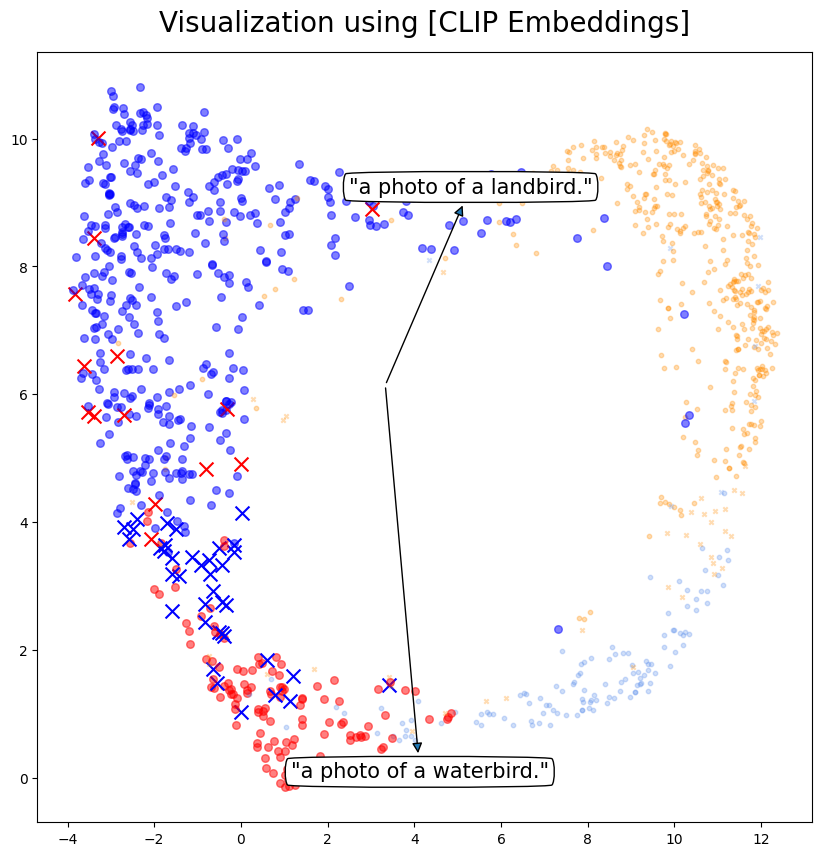

100%|██████████| 1/1 [00:23<00:00, 23.21s/it]


In [219]:
num_nn_text_ebd = 1 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Bestmodel)(skip)CLIP_ZS_class_n{num_nn_text_ebd}.png"

vis_handler.vis_text = False
vis_handler.all_candidate = True
vis_handler.loc = 'skip'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)

## Figure 4 (Spurious attributes)

In [181]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

# vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a land-background.']), dict_keys(['a photo of a water-background.'])]


In [182]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 3 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11790, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11805, 1024)
> Start Umap fitting.... (# of samples 11805)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Bestmodel)CLIP_ZS_background_n3.png!


<Figure size 2400x1000 with 0 Axes>

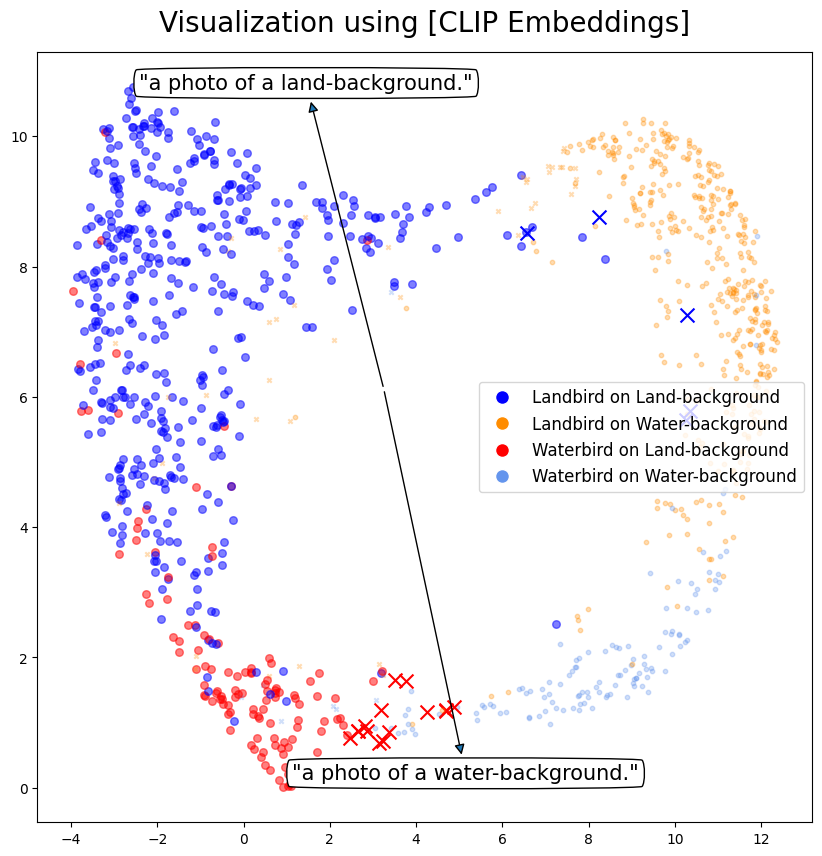

100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


In [183]:
num_nn_text_ebd = 3 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Bestmodel)CLIP_ZS_background_n{num_nn_text_ebd}.png"

vis_handler.vis_text = True
vis_handler.all_candidate = True
vis_handler.loc = 'center right'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)

## Not reported (Group)

In [170]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

# vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a landbird on land-background.']), dict_keys(['a photo of a landbird on water-background.']), dict_keys(['a photo of a waterbird on land-background.']), dict_keys(['a photo of a waterbird on water-background.'])]


In [171]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 1 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11792, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11807, 1024)
> Start Umap fitting.... (# of samples 11807)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Bestmodel)CLIP_ZS_group_n1.png!


<Figure size 2400x1000 with 0 Axes>

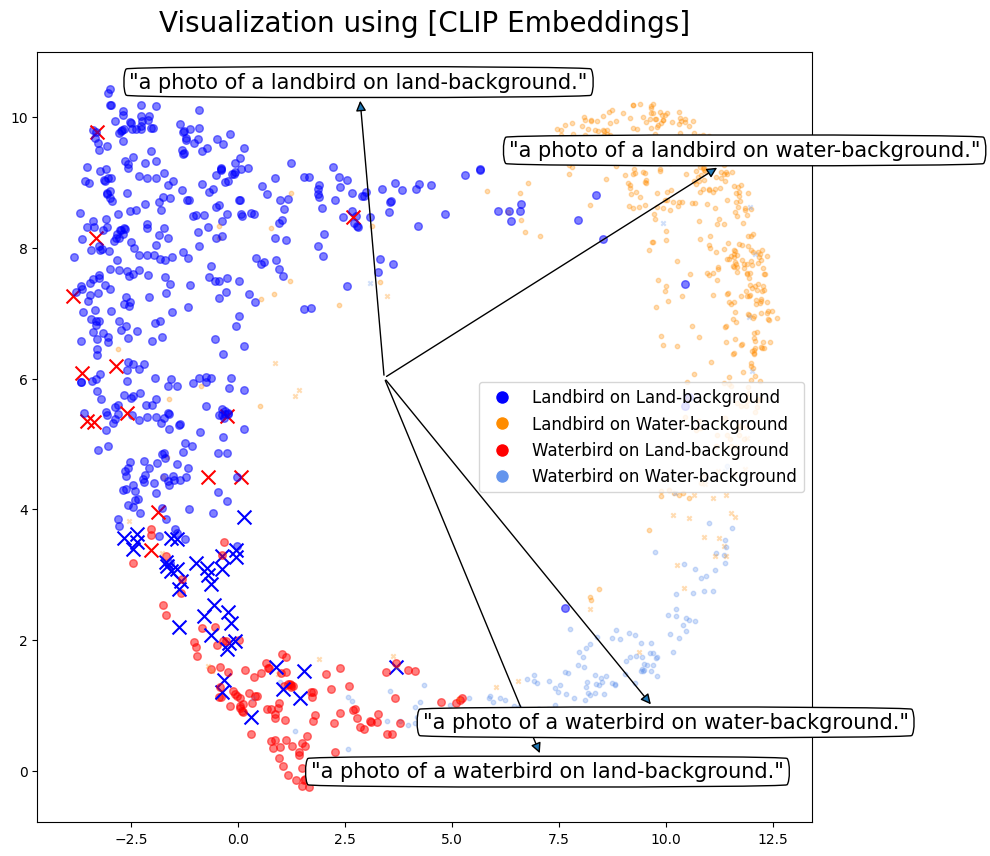

100%|██████████| 1/1 [00:23<00:00, 23.81s/it]


In [172]:
num_nn_text_ebd = 1 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Bestmodel)CLIP_ZS_group_n{num_nn_text_ebd}.png"

vis_handler.vis_text = False
vis_handler.all_candidate = True
vis_handler.loc = 'center right'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)

# (2) ERM Adapter - baseline for figure.

In [228]:
path_root = "/home/jinsu/workstation/project/debiasing-multi-modal/results/embeddings_unnormalized/waterbirds/RN50/"
name_best_model = "im_clip_t_clip_class_tl_adapter_t_class_lr_1.0_bs_512.pth"

path_best_model = os.path.join(path_root, name_best_model)

In [229]:
opt.tl_method = 'adapter'

classifier.load_state_dict(torch.load(path_best_model))
# opt.init_near_identity = False
# multiple_adapter, criterion = set_model_multiple_adapter(opt, classifier) # model,  # CE

# multiple_adapter.load_state_dict(torch.load(path_best_model))
# # ((_, _, train_ca_group_acc), 
#      (train_total_embeddings, train_total_meta_results)) = validate_adapter_with_return(opt, train_loader, classifier, ce_loss, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Train(Initial Adapter)')

<All keys matched successfully>

In [230]:
((_, _, train_ce_group_acc), 
     (train_total_embeddings, train_total_meta_results)) = validate_adapter_with_return(opt, train_loader, classifier, criterion, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Train(Initial Adapter)')

((_, _, val_ce_group_acc), 
     (val_total_embeddings, val_total_meta_results)) = validate_adapter_with_return(opt, val_loader, classifier, criterion, get_yp_func, train_group_ratio, target=opt.train_target, print_label=f'Val(After CE)')
((_, _, test_ce_group_acc), 
     (test_total_embeddings, test_total_meta_results)) = validate_adapter_with_return(opt, test_loader, classifier, criterion, get_yp_func, train_group_ratio, target='class', print_label=f'Test(After CE)')

Train(Initial Adapter): {'weighted_mean_acc': 0.9973, 'worst_acc': 0.9643, 'acc_0_0': 0.9991, 'acc_0_1': 0.9783, 'acc_1_0': 0.9643, 'acc_1_1': 0.9962, 'mean_acc': 0.9973}
Val(After CE): {'weighted_mean_acc': 0.9613, 'worst_acc': 0.6767, 'acc_0_0': 0.9743, 'acc_0_1': 0.7082, 'acc_1_0': 0.6767, 'acc_1_1': 0.9774, 'mean_acc': 0.8382}
Test(After CE): {'weighted_mean_acc': 0.9613, 'worst_acc': 0.69, 'acc_0_0': 0.9854, 'acc_0_1': 0.7047, 'acc_1_0': 0.69, 'acc_1_1': 0.9408, 'mean_acc': 0.8385}


## Figure 1 (Class)

In [231]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a landbird.']), dict_keys(['a photo of a waterbird.'])]


In [232]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 1 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11790, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11805, 1024)
> Start Umap fitting.... (# of samples 11805)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Adapter)(skip)CLIP_ZS_class_n1.png!


<Figure size 2400x1000 with 0 Axes>

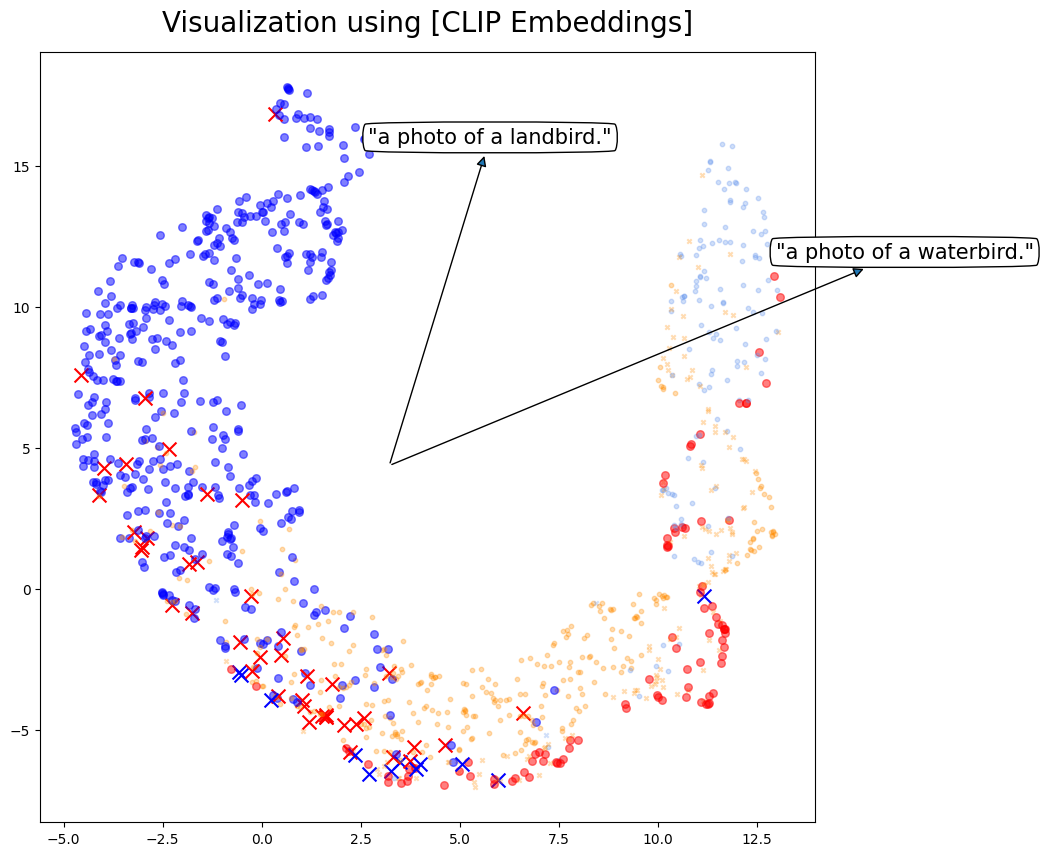

100%|██████████| 1/1 [00:22<00:00, 22.15s/it]


In [233]:
num_nn_text_ebd = 1 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Adapter)(skip)CLIP_ZS_class_n{num_nn_text_ebd}.png"

vis_handler.vis_text = False
vis_handler.all_candidate = True
vis_handler.loc = 'skip'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)

## Figure 4 (Background)

In [202]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

# vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a land-background.']), dict_keys(['a photo of a water-background.'])]


In [203]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 1 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11790, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11805, 1024)
> Start Umap fitting.... (# of samples 11805)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Adapter)CLIP_ZS_background_n1.png!


<Figure size 2400x1000 with 0 Axes>

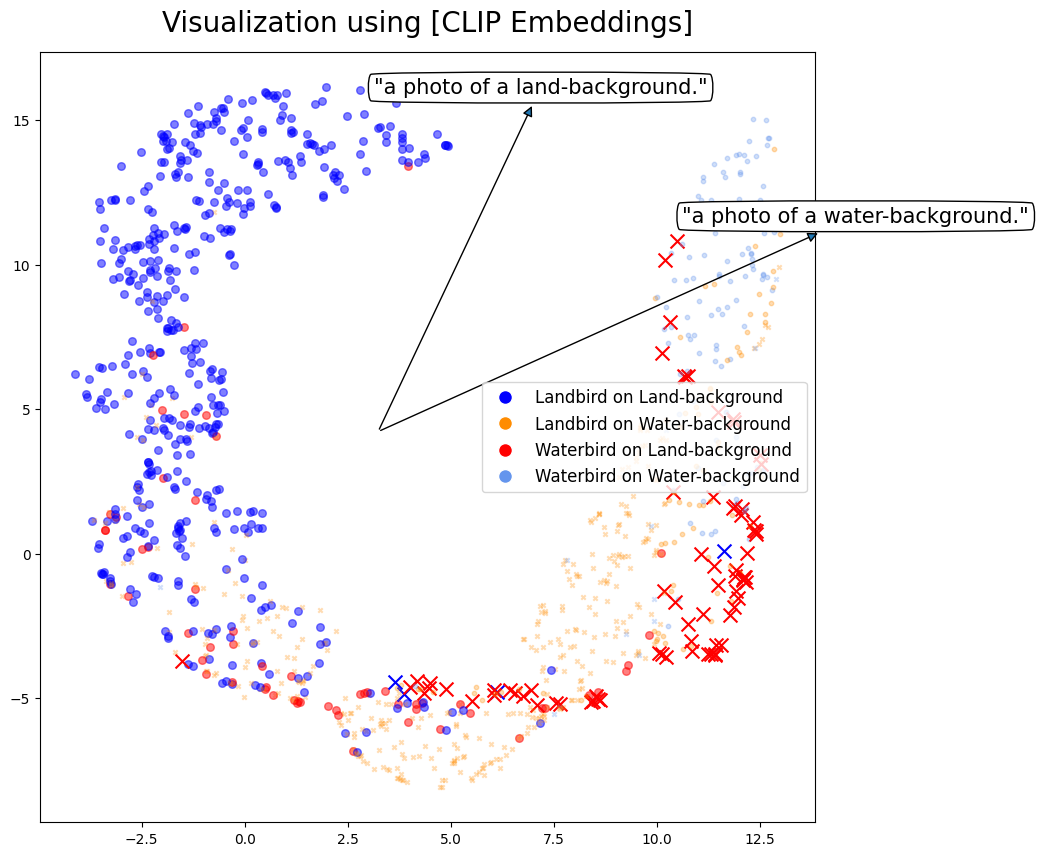

100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


In [198]:
num_nn_text_ebd = 1 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Adapter)CLIP_ZS_background_n{num_nn_text_ebd}.png"

vis_handler.vis_text = True
vis_handler.all_candidate = True
vis_handler.loc = 'center right'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)

## Not reported (Group)

In [192]:
vis_handler = VisHandler(opt)
# vis_handler.SaveWaterbirdsDatasets(trainset)
# vis_handler.SaveWaterbirdsLoaders(train_loader, val_loader, test_loader)

# vis_handler.SaveTextEmbeddings(opt.text_embedding_dir) # class 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
# vis_handler.SaveTextEmbeddings(opt.text_spurious_embedding_dir) # spurious 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
vis_handler.SaveTextEmbeddings(opt.text_group_embedding_dir) # group 임베딩 경로 (unnormalized!) (c.f. clip_inference_including_group_with_unnorm.py)
print("Saved Embeddings : ", [feature.keys() for feature in vis_handler.text_embeddings])

# vis_handler.SaveModel(classifier)
vis_handler.SaveUtils(criterion, get_yp_func, train_group_ratio)
# vis_handler.SaveZeroShotResults(vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader) # Zero-shot Prediction 수행

Saved Embeddings :  [dict_keys(['a photo of a landbird on land-background.']), dict_keys(['a photo of a landbird on water-background.']), dict_keys(['a photo of a waterbird on land-background.']), dict_keys(['a photo of a waterbird on water-background.'])]


In [193]:
vis_handler.pre_extracted_embeddings = ((train_total_embeddings, train_total_meta_results), (val_total_embeddings, val_total_meta_results), (test_total_embeddings, test_total_meta_results))

(4795, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
(1199, 1024) dict_keys(['targets', 'spuriouss', 'groups', 'predictions', 'predictions_spurious'])
> Calculating [Group-wise] Statistics...


Number of dataset : tr : [4795], val : [1199], test : [5794]
ㄴ total embedddings  :  (11788, 1024)
Add [text] embedding to umap-pool
> Calculate 1 Nearest samples for visualization of [text prompts]
ㄴ total embedddings  :  (11792, 1024)
Add [group] (mean) embedding to umap-pool
ㄴ total embedddings  :  (11807, 1024)
> Start Umap fitting.... (# of samples 11807)(dim 1024)
Sub title Train set
Sub title Test set
Saved umap to (Presentation)(Ada[ter])CLIP_ZS_group_n1.png!


<Figure size 2400x1000 with 0 Axes>

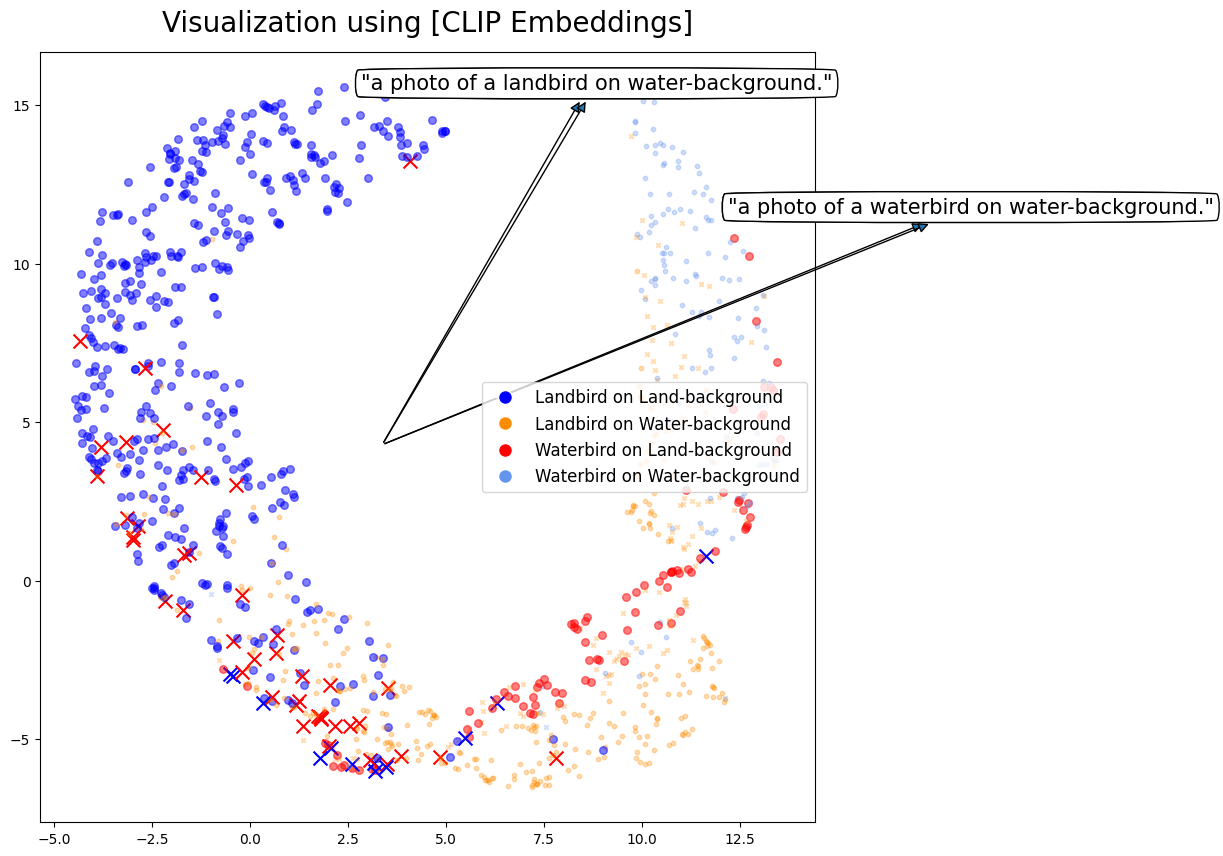

100%|██████████| 1/1 [00:22<00:00, 22.60s/it]


In [194]:
num_nn_text_ebd = 1 # 각각의 Text embedding에서 제일 가까운 [num_nn_text_ebd] 개수의 이미지 임베딩을 뽑아, 평균낸 임베딩을 해당 Text embedding의 visualization에 사용함. 
set_bbox=True # True: 가독성 그나마 좋아지나, 가끔 가릴 때 있음.
save_id_suffix =f"CLIP_ZS_class_n{num_nn_text_ebd}" # 파일 저장용 ("figure/..._save_id_suffix.png")
opt.fpath = f"(Presentation)(Ada[ter])CLIP_ZS_group_n{num_nn_text_ebd}.png"

vis_handler.vis_text = False
vis_handler.all_candidate = True
vis_handler.loc = 'center right'
vis_handler.VisRepForPT(train_loader, val_loader, test_loader, pre_extracted_embeddings = vis_handler.pre_extracted_embeddings, label_types = ["group"], reduced_dim=2,
                      vis_text=vis_handler.vis_text, all_candidate = vis_handler.all_candidate, loc = vis_handler.loc, text_ebd = vis_handler.text_embeddings, group_mean_ebd = True, figsize=(24, 10),
                      num_nn_text_ebd = num_nn_text_ebd, set_bbox = set_bbox, save_id_suffix = save_id_suffix)